In [455]:
import sys
sys.path.append('/Users/jcmeaveojeda/opt/anaconda3/lib/python3.8/site-packages')
sys.path.append('/Users/jcmeaveojeda/Documents/Stanford University/Courses/Fall 2021/CS230/cs230/lib/python3.8/site-packages')

import numpy as np
import pandas as pd

import os
print(os.listdir("../input/facial-expression/fer2013/"))

['fer2013.csv', '.DS_Store', 'fer2013.csv.zip']


In [456]:
import tensorflow as tf

import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [494]:
# get the data
filname = '../input/facial-expression/fer2013/fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('../input/facial-expression/fer2013/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [457]:
# Build X and Y from dataset
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y


In [495]:
X, Y = getData(filname)
num_class = len(set(Y))
print('Num Classes: ', num_class)
N, D = X.shape
X = X.reshape(N, 48, 48, 1)
print('Num Examples: ', N)

Num Classes:  7
Num Examples:  35887


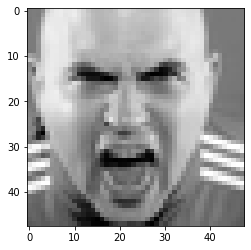

In [459]:
# Example of data
example = image.array_to_img(X[22])
plt.imshow(example)

In [460]:
# Save each image as a PNG file so that MaskTheFace can run on the entire dataset
# Only needs to run once

# for i in range(N):
#     img = image.array_to_img(X[i])
#     img_filename = '../output/img' + str(i) + '.png'
#     img.save(img_filename)


In [461]:
# Use output of previous step as the input to MaskTheFace, 
# then use that output as the input for the next step

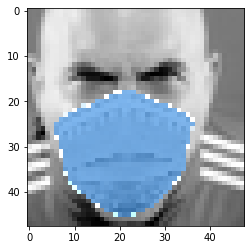

In [462]:
# Example of masked output
example = image.load_img('../output_masked/img22_surgical.png')
plt.imshow(example)

In [496]:
# Build X and Y from masked images dataset
X_masked = []
Y_masked = []
class_count = np.zeros((7))

for i in range(N):
    img_filename = '../output_masked/img' + str(i) + '_surgical.png'
    if os.path.exists(img_filename):
        img = image.load_img(img_filename) # add grayscale=True parameter for shape (48,48,1)
        img_arr = image.img_to_array(img)
        img_arr = np.expand_dims(img_arr, axis = 0)
        
        # Multi Class
        X_masked.append(img_arr)
        Y_masked.append(Y[i])
        class_count[Y[i]] += 1
        
#         # Multi Class (less happy)
#         if Y[i] == 3 and class_count[3] < 3500:
#             X_masked.append(img_arr)
#             Y_masked.append(Y[i])
#             class_count[Y[i]] += 1
#         elif Y[i] != 3:
#             X_masked.append(img_arr)
#             Y_masked.append(Y[i])
#             class_count[Y[i]] += 1
        
#         # Binary Happy vs Not Happy classifier:
#         num_class = 2
#         if Y[i] == 3 and class_count[1] < 7000:
#             X_masked.append(img_arr)
#             Y_masked.append(1)
#             class_count[1] += 1
#         elif Y[i] != 3 and class_count[0] < 7000:
#             X_masked.append(img_arr)
#             Y_masked.append(0)
#             class_count[0] +=1
#         if class_count[0] == 7000 and class_count[1] == 7000: break
        
X = X_masked
Y = Y_masked
n = len(X_masked)
X, Y = np.array(X) / 255.0, np.array(Y)
X = X.reshape(n, 48, 48, 3) # change '3' to '1' for grayscale
    

In [521]:
print('Num Examples After Preprocessing: ', n)
print('Shape: ', X.shape)

## Multi Class
print('Num Angry: ', class_count[0])
print('Num Disgust: ', class_count[1])
print('Num Fear: ', class_count[2])
print('Num Happy: ', class_count[3])
print('Num Sad: ', class_count[4])
print('Num Surprise: ', class_count[5])
print('Num Neutral: ', class_count[6])

# # Binary
# print('Num Not Happy: ', class_count[0])
# print('Num Happy: ', class_count[1])


Num Examples After Preprocessing:  25018
Shape:  (25018, 48, 48, 3)
Num Angry:  3415.0
Num Disgust:  429.0
Num Fear:  3184.0
Num Happy:  7000.0
Num Sad:  3352.0
Num Surprise:  2977.0
Num Neutral:  4661.0


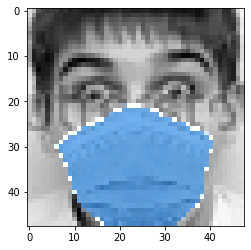

In [628]:
# Random masked picture generator for self quizing
import random
num = random.randint(0, n-1)
img = image.array_to_img(X[num])
plt.imshow(img)

In [629]:
# Print expression for image above
print(label_map[Y[num]])

Surprise


In [498]:
from sklearn.model_selection import train_test_split

# 90-10 split between train and dev sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [470]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import batch_normalization
from keras.applications.resnet import ResNet50


In [492]:
def my_model():
    model = Sequential()
    
#     # Original architecture of model
#     input_shape = (48,48,1)
#     model.add(Conv2D(32, (7, 7), input_shape=input_shape,activation='relu', padding='same'))
#     model.add(Conv2D(32, (7, 7), activation='relu', padding='same'))
#     model.add(batch_normalization.BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
#     model.add(Flatten())
#     model.add(Dense(128))
#     model.add(batch_normalization.BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.2))
    
    
    # ResNet50 pretrained model:
    # note: unlike above, ResNet50 requires input shape axis -1 = 3 (3 color channels)
    input_shape = (48,48,3)
    model.add(ResNet50(input_shape=input_shape, include_top=False, weights='imagenet', pooling='max'))
    for layer in model.layers:
        layer.trainable = False
    
    
    
    # Multiple Class
    model.add(Dense(7))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    

#     # Binary Classifier
#     input_shape = (48,48,3)
#     model.add(Conv2D(32, (7, 7), input_shape=input_shape, strides = (1, 1), padding='same'))
#     model.add(batch_normalization.BatchNormalization(axis = 3))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Flatten())
#     model.add(Dense(2, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer='adam')

    return model
    

#model = my_model()
model = keras.models.load_model('MultiClassModel.h5')
model.summary()
    
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
 activation (Activation)     (None, 7)                 0         
                                                                 
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
_________________________________________________________________


In [483]:
# Run the model (Not needed if a model was loaded in previous step)

# path_model='model_filter.h5' # save model at this location after each epoch
# K.clear_session() # destroys the current graph and builds a new one
# model=my_model() # create the model
# K.set_value(model.optimizer.lr,0.0001) # set the learning rate
# # fit the model
# h=model.fit(x=X_train,     
#             y=y_train, 
#             batch_size=8,
#             epochs=40, 
#             verbose=1, 
#             validation_data=(X_test,y_test),
#             shuffle=True,
#             callbacks=[
#                 ModelCheckpoint(filepath=path_model),
#             ]
#             )

In [500]:
print("Evaluate on train data")
results = model.evaluate(X_train, y_train)
print("train loss, train acc:", results)

Evaluate on train data
704/704 [==============================] - 83s 118ms/step - loss: 1.6509 - accuracy: 0.3432
train loss, train acc: [1.6508570909500122, 0.3431781828403473]


In [501]:
print("Evaluate on validation data")
results = model.evaluate(X_test, y_test)
print("val loss, val acc:", results)

Evaluate on validation data
79/79 [==============================] - 9s 108ms/step - loss: 1.6766 - accuracy: 0.3345
val loss, val acc: [1.6766481399536133, 0.33453238010406494]


In [485]:
# Define the labels

# Multi Class
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

# # Binary
# objects = ('not happy', 'happy')

y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [486]:
# Plots a bar graph of each emotion's probability
def emotion_analysis(emotions, emotion):
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.xlabel('emotion')
    title = 'Prediction for picture with label = "' + emotion + '"'
    plt.title(title)
    
plt.show()

**Real Time Expression Prediction**

In [475]:
# Turn each input image into grayscale before adding mask with MaskTheFace
# Only need to do this once
# path1 = '../input/myimages/'
# path2 = '../input/myimages_preprocessed/'

# folder = os.listdir(path1)
# for file in folder:
#     img = image.load_img(path1 + file, grayscale = True)
#     img.save(path2 + file)


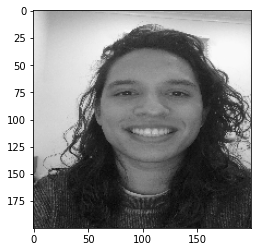

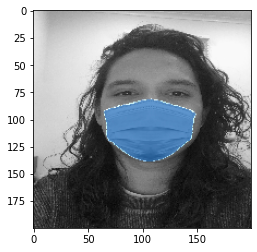

True Expression:  happy
Expression Prediction: happy


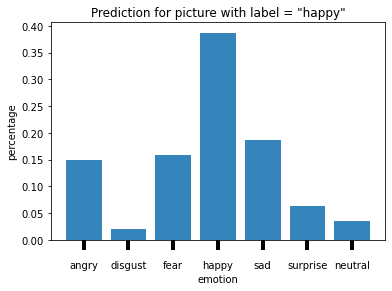

In [645]:
# Test on a picture of me
orig_img_file = '../input/myimages_preprocessed/JCHappy.jpg'
masked_img_file = '../input/myimages_preprocessed_masked/JCHappy_surgical.jpg'
emotion = 'happy'

img = image.load_img(masked_img_file, target_size=(48, 48)) # add grayscale=True parameter for shape (48,48,1)
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)

x = np.array(x, 'float32')
x = x.reshape([48, 48, 3]); # remove '3' for grayscale

# Show image being tested (original image and masked image)
orig_img = image.load_img(orig_img_file, target_size=(200, 200))
masked_img=image.load_img(masked_img_file, target_size=(200, 200))
plt.gray()
plt.imshow(orig_img)
plt.figure()
plt.imshow(masked_img)
plt.show()

# Find emotion with highest probability
m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('True Expression: ', emotion)
print('Expression Prediction:',objects[ind])

# Plot bar graph of probabilities
plt.figure()
emotion_analysis(custom[0], emotion)
        